# Variant effect prediction files for cCREs

Files are tab-separated in the following format
```text
chr4:156105483-156105721 chr4:156105452-156105752 pos=156105483 ref=G G -0.32947034
```
They contain the following information:
- cCRE region in `chr#:start-end` genome region notation
- sequence bin used for prediction; centered on cCRE and length based on what model was trained with (same genome region notation)
- `pos=NNNNNNN`: chromosome position being mutated
- `ref=X`: reference genome allele (=X) at this position
- `Y`: the allele being tested for the sequence bin
- the activation value predicted for the sequence bin with allele `Y` in the position being mutated

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt

In [2]:
DATADIR = Path("data")
pred_file = DATADIR / "pred999.txt"

In [3]:
def read_pred_table(pred_file, convFC=lambda x: x/np.log(2), FC_name="log2FC"):
    # last column is FC, which can be neg and thus have a minus sign
    pred_vals = pd.read_csv(pred_file, sep="\t", index_col=False, header=None,
                            usecols=[5], names=[FC_name])
    # convert as desired
    pred_vals[FC_name] = convFC(pred_vals[FC_name])
    # get the remaining columns and merge
    cols = ["cre_chrom", "cre_start", "cre_end",
            "bin_chrom", "bin_start", "bin_end",
            "allele_pos", "ref_allele", "allele"]
    pred_table = pd.read_csv(pred_file, sep="\t|:|=|-", index_col=False, header=None,
                             usecols=[0, 1, 2, 3, 4, 5, 7, 9, 10], names=cols,
                             engine="python")
    pred_table = pred_table.merge(pred_vals, left_index=True, right_index=True)
    # compute relative activation of allele to ref
    refFC = pred_table.loc[pred_table["ref_allele"] == pred_table["allele"], [FC_name]]
    refFC = refFC.loc[refFC.index.repeat(4)].reset_index(drop=True)
    pred_table["FC_to_ref"] = pred_table[FC_name] - refFC[FC_name]
    # done
    return pred_table

In [4]:
pred_table = read_pred_table(pred_file)

In [5]:
pred_table

,cre_chrom,cre_start,cre_end,bin_chrom,bin_start,bin_end,allele_pos,ref_allele,allele,log2FC,FC_to_ref
0,chr4,156105483,156105721,chr4,156105452,156105752,156105483,G,G,-0.475325,0.000000
1,chr4,156105483,156105721,chr4,156105452,156105752,156105483,G,C,-0.487121,-0.011796
2,chr4,156105483,156105721,chr4,156105452,156105752,156105483,G,A,-0.461409,0.013916
3,chr4,156105483,156105721,chr4,156105452,156105752,156105483,G,T,-0.456129,0.019196
4,chr4,156105483,156105721,chr4,156105452,156105752,156105484,A,G,-0.483387,-0.008061
...,...,...,...,...,...,...,...,...,...,...,...
1010007,chr5,1777713,1777943,chr5,1777678,1777978,1777941,G,T,0.113811,-0.029922
1010008,chr5,1777713,1777943,chr5,1777678,1777978,1777942,G,G,0.143734,0.000000
1010009,chr5,1777713,1777943,chr5,1777678,1777978,1777942,G,C,0.133421,-0.010312
1010010,chr5,1777713,1777943,chr5,1777678,1777978,1777942,G,A,0.138082,-0.005651


## Conduct checks of basic assumptions

For example:

1. There are no cCRE regions for which predictions are reported for more than a single sequence bin.


In [6]:
duckdb.sql("select cre_chrom, cre_start, cre_end, "
           "count(distinct bin_start), min(bin_start), max(bin_start) "
           "from pred_table "
           "group by cre_chrom, cre_start, cre_end "
           "having count(distinct bin_start) > 1")

┌───────────┬───────────┬─────────┬───────────────────────────┬────────────────┬────────────────┐
│ cre_chrom │ cre_start │ cre_end │ count(DISTINCT bin_start) │ min(bin_start) │ max(bin_start) │
│  varchar  │   int64   │  int64  │           int64           │     int64      │     int64      │
├───────────┴───────────┴─────────┴───────────────────────────┴────────────────┴────────────────┤
│                                            0 rows                                             │
└───────────────────────────────────────────────────────────────────────────────────────────────┘

2. There are no allele positions outside of the boundaries of the sequence bin.

In [7]:
duckdb.sql("select cre_chrom, cre_start, cre_end "
           "from pred_table "
           "where allele_pos < bin_start or allele_pos >= bin_end")

┌───────────┬───────────┬─────────┐
│ cre_chrom │ cre_start │ cre_end │
│  varchar  │   int64   │  int64  │
├───────────┴───────────┴─────────┤
│             0 rows              │
└─────────────────────────────────┘

3. Predictions are reported for the entire length of the CRE if it is shorter than the length of the sequence bin (300bp), and for the length of the sequence bin otherwise.

In [8]:
duckdb.sql("select cre_chrom, cre_start, cre_end, count(distinct allele_pos) "
           "from pred_table "
           "where (cre_end - cre_start) < (bin_end - bin_start) "
           "group by cre_chrom, cre_start, cre_end "
           "having count(distinct allele_pos) != (cre_end - cre_start)")

┌───────────┬───────────┬─────────┬────────────────────────────┐
│ cre_chrom │ cre_start │ cre_end │ count(DISTINCT allele_pos) │
│  varchar  │   int64   │  int64  │           int64            │
├───────────┴───────────┴─────────┴────────────────────────────┤
│                            0 rows                            │
└──────────────────────────────────────────────────────────────┘

In [9]:
duckdb.sql("select bin_chrom, bin_start, bin_end, count(distinct allele_pos) "
           "from pred_table "
           "where (cre_end - cre_start) >= (bin_end - bin_start) "
           "group by bin_chrom, bin_start, bin_end "
           "having count(distinct allele_pos) != bin_end - bin_start")

┌───────────┬───────────┬─────────┬────────────────────────────┐
│ bin_chrom │ bin_start │ bin_end │ count(DISTINCT allele_pos) │
│  varchar  │   int64   │  int64  │           int64            │
├───────────┴───────────┴─────────┴────────────────────────────┤
│                            0 rows                            │
└──────────────────────────────────────────────────────────────┘

4. Predictions are reported for each possible allele at each position.

In [10]:
duckdb.sql("select bin_chrom, allele_pos, count(distinct allele) "
           "from pred_table "
           "group by bin_chrom, allele_pos "
           "having count(distinct allele) != 4")

┌───────────┬────────────┬────────────────────────┐
│ bin_chrom │ allele_pos │ count(DISTINCT allele) │
│  varchar  │   int64    │         int64          │
├───────────┴────────────┴────────────────────────┤
│                     0 rows                      │
└─────────────────────────────────────────────────┘

5. All sequence bins overlap with the cCRE region.

In [11]:
duckdb.sql("select cre_chrom, cre_start, cre_end "
           "from pred_table "
           "where bin_chrom != cre_chrom or "
           "bin_start >= cre_end or bin_end < cre_start")

┌───────────┬───────────┬─────────┐
│ cre_chrom │ cre_start │ cre_end │
│  varchar  │   int64   │  int64  │
├───────────┴───────────┴─────────┤
│             0 rows              │
└─────────────────────────────────┘

6. The cCRE region and the sequence bin are centered over each other.

In [12]:
duckdb.sql("select cre_chrom, cre_start, cre_end, bin_start, bin_end, "
           " (bin_start/2.0 + bin_end/2.0) as bin_mid, "
           " (cre_start/2.0 + cre_end/2.0) as cre_mid "
           "from pred_table "
           "where floor(bin_start/2.0 + bin_end/2.0) != floor(cre_start/2.0 + cre_end/2.0)")

┌───────────┬───────────┬─────────┬───────────┬─────────┬─────────┬─────────┐
│ cre_chrom │ cre_start │ cre_end │ bin_start │ bin_end │ bin_mid │ cre_mid │
│  varchar  │   int64   │  int64  │   int64   │  int64  │ double  │ double  │
├───────────┴───────────┴─────────┴───────────┴─────────┴─────────┴─────────┤
│                                  0 rows                                   │
└───────────────────────────────────────────────────────────────────────────┘

## Histogram of activations relative to reference

We preclude from this all reference allele predictions, because by definition there is one for each position (and thus many), and they are all zero on log scale, thus creating a dominating peak at zero.

In [13]:
pred_norefs = duckdb.sql("select cre_chrom, cre_start, allele_pos, allele, FC_to_ref "
                         "from pred_table "
                         "where ref_allele != allele").df()

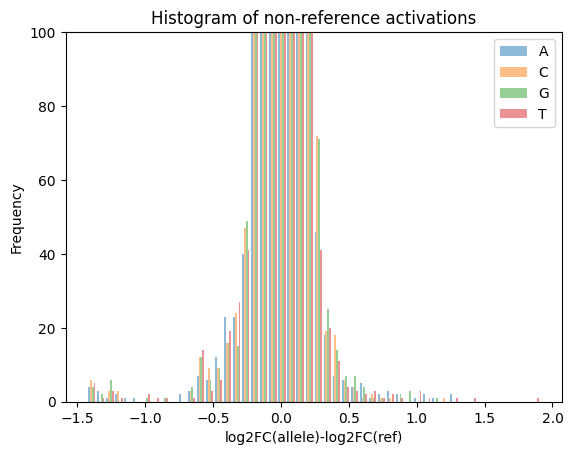

In [14]:
barc = plt.hist((pred_norefs.loc[(pred_norefs["allele"] == "A"),"FC_to_ref"],
                 pred_norefs.loc[(pred_norefs["allele"] == "C"),"FC_to_ref"],
                 pred_norefs.loc[(pred_norefs["allele"] == "G"),"FC_to_ref"],
                 pred_norefs.loc[(pred_norefs["allele"] == "T"),"FC_to_ref"]),
                bins=50, alpha=0.5, label=['A','C','G','T'])
plt.ylim(0, 100)
plt.xlabel('log2FC(allele)-log2FC(ref)')
plt.ylabel('Frequency')
plt.title('Histogram of non-reference activations')
plt.legend()
plt.show()

## Profiles of predicted variant effect over cCRE region

Strictly speaking, we have predictions for the full cCRE region only when it is completely covered by a sequence bin. If it partially overlaps with a sequence bin, we have variant predictions for the larger overlapping part.

Stronger predicted variant effects are rare enough that many cCREs don't even have at least one for at least one variant. To select for profiles with at least some signal for at least one position, we select those cCREs with at least one activation > 0.2 (log2 scale).

In [28]:
signif_cres = duckdb.sql(
    "select cre_chrom, cre_start from pred_table "
    "where FC_to_ref > 0.2 "
    "group by cre_chrom, cre_start "
    "order by cre_chrom, cre_start").df()

In [29]:
signif_cres

,cre_chrom,cre_start
0,chr4,156105483
1,chr4,156162885
2,chr4,156242868
3,chr4,156309124
4,chr4,156363353
...,...,...
341,chr5,1665186
342,chr5,1733420
343,chr5,1756522
344,chr5,1762711


In [30]:
def preds_for_cre(pred_table, cre: (str, int)):
    (chr, pos) = cre
    preds = duckdb.sql(
        "select cre_chrom, cre_start, allele_pos, allele, FC_to_ref "
        "from pred_table " +
        f"where cre_chrom = '{chr}' " +
        f"and cre_start = {pos}").df()
    return preds

In [31]:
def plot_variant_effect_profiles(preds, colors = ["blue","orange","green","red"], ylim=None):
    bases = ['A','C','G','T']
    
    fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0)
    if ylim:
        axs[0].set_ylim(ylim)

    for ax, b, c in zip(axs, bases, colors):
        ax.plot(preds.loc[preds['allele'] == b, ['allele_pos']],
                preds.loc[preds['allele'] == b, ['FC_to_ref']],
                color=c)
        ax.set_ylabel(f"Allele={b}")
    axs[-1].set_xlabel(f"Position on {signif_cres.loc[cre,'cre_chrom']}")
    plt.show()

In [35]:
cre = 15 # choose one
cre_preds = preds_for_cre(pred_table,
                          signif_cres.iloc[cre][["cre_chrom", "cre_start"]])

In [36]:
cre_preds

,cre_chrom,cre_start,allele_pos,allele,FC_to_ref
0,chr4,157315425,157315425,G,-0.013549
1,chr4,157315425,157315425,C,0.000149
2,chr4,157315425,157315425,A,0.000429
3,chr4,157315425,157315425,T,0.000000
4,chr4,157315425,157315426,G,-0.002157
...,...,...,...,...,...
1175,chr4,157315425,157315718,T,0.000000
1176,chr4,157315425,157315719,G,0.004115
1177,chr4,157315425,157315719,C,0.000861
1178,chr4,157315425,157315719,A,0.003521


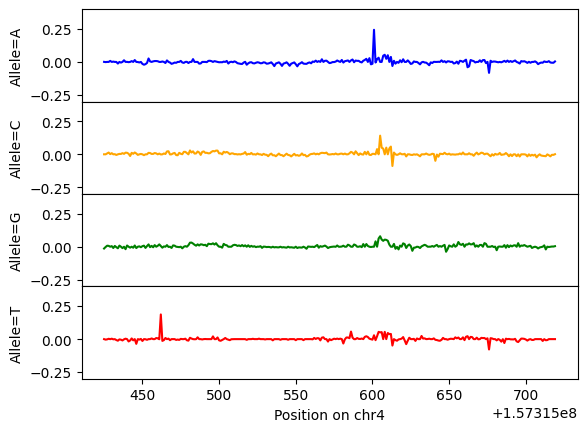

In [37]:
plot_variant_effect_profiles(cre_preds, ylim=(-0.3, 0.4))